Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Found 16 mask files in Membrane_Adjusted folder.
  Found Membrane_Adjusted file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_membrane_mask_golgi_removed.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001
  Found Membrane_Adjusted file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq003_membrane_mask_golgi_removed.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq003
  Found Membrane_Adjusted file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq005_membrane_mask_golgi_removed.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq005
  Found Membrane_Adjusted file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq004_membrane_mask_golgi_removed.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq004
  Found Membrane_Adjusted file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq006_membrane_mask_golgi_remov

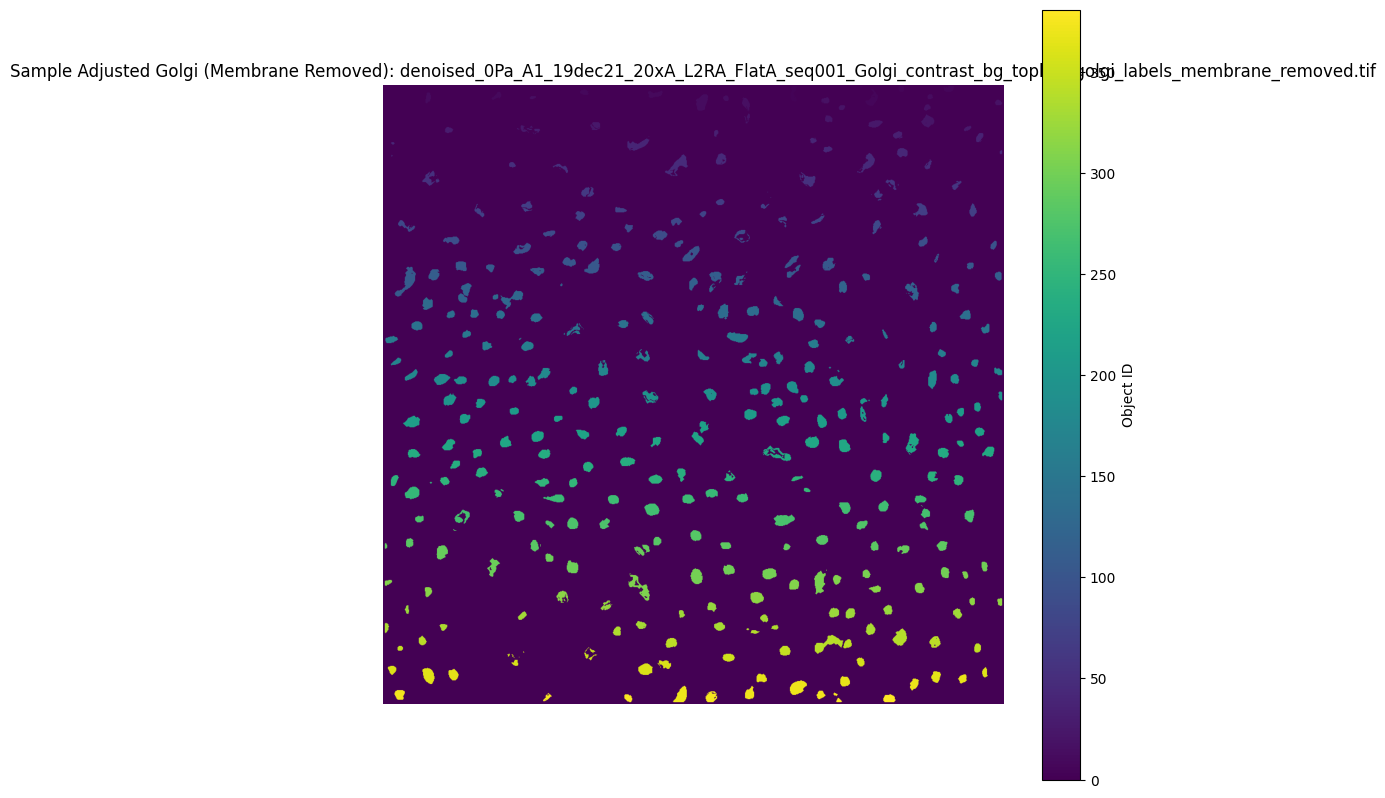

Displayed sample adjusted golgi image: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_Golgi_contrast_bg_tophat_golgi_labels_membrane_removed.tif


In [1]:
# Import necessary libraries
from google.colab import drive
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
import tifffile
from pathlib import Path

# Set up paths - update these to match your directory structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-1"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-1/Golgi_Adjusted"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    """
    Extract the sample ID from filenames like:
    - denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq005_membrane_mask
    - denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq005_Golgi_contrast_bg_tophat_golgi_adjusted_binary

    We want to extract everything before the specific component identifier
    """
    # Extract the base sample ID - everything up to seq### part
    parts = str(filename).split('_')
    seq_part = None
    for i, part in enumerate(parts):
        if part.startswith('seq'):
            seq_part = i
            break

    if seq_part is not None:
        # Include the seq### part in the sample ID
        base_id = '_'.join(parts[:seq_part+1])
        return base_id

    # Fallback method if seq### pattern is not found
    return None

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in
    component_folders = ['Membrane_Adjusted', 'Golgi']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all mask files in the component folder (may end with .tif, _mask, etc.)
        files = [f for f in os.listdir(component_dir) if
                any(ext in f.lower() for ext in ['.tif', 'mask', 'binary', 'labels'])]
        print(f"Found {len(files)} mask files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                print(f"  Found {component} file: {file}")
                print(f"  Sample ID: {sample_id}")

                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                component_key = component.lower()
                file_dict[sample_id][component_key] = os.path.join(component_dir, file)
            else:
                print(f"  Couldn't extract sample ID from: {file}")

    # Print all extracted sample IDs and their components
    print("\nExtracted sample IDs:")
    for sample_id, components in file_dict.items():
        print(f"  Sample: {sample_id}")
        for comp, path in components.items():
            print(f"    {comp}: {os.path.basename(path)}")

    # Find samples that have all required components (Membrane_Adjusted and Golgi)
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have both membrane_adjusted and golgi data
        if 'membrane_adjusted' in components and 'golgi' in components:
            complete_samples.append(sample_id)
        else:
            missing = []
            if 'membrane_adjusted' not in components:
                missing.append('membrane_adjusted')
            if 'golgi' not in components:
                missing.append('golgi')
            print(f"  Sample {sample_id} is missing: {', '.join(missing)}")

    print(f"Found {len(complete_samples)} complete samples with membrane_adjusted and golgi data.")

    return file_dict, complete_samples

# Function to create adjusted golgi image (removing areas that overlap with membrane)
def create_adjusted_golgi(golgi_img, membrane_img):
    """
    Create golgi image with pixels set to 0 where membrane is present
    """
    # Convert to binary if not already
    membrane_binary = membrane_img > 0

    # For labeled golgi images, we want to keep the labels
    if golgi_img.dtype == np.uint32 or np.max(golgi_img) > 1:
        # This is a labeled image, so keep the original labels
        golgi_adjusted = golgi_img.copy()
        # Set pixels to 0 where membrane exists
        golgi_adjusted[membrane_binary] = 0

        # Re-label connected components since removing overlap may split objects
        # Create a binary mask from the labeled image
        golgi_binary = golgi_adjusted > 0
        # Label the connected components in the binary mask
        labeled_golgi = measure.label(golgi_binary)

        return labeled_golgi
    else:
        # It's a binary mask
        golgi_binary = golgi_img > 0
        # Create the mask where golgi does not overlap with membrane
        golgi_without_membrane = golgi_binary.copy()
        golgi_without_membrane[membrane_binary] = 0

        # Re-label connected components
        labeled_golgi = measure.label(golgi_without_membrane)

        return labeled_golgi

# Function to process a single sample
def process_sample(sample_id, file_dict, output_dir):
    print(f"\nProcessing sample: {sample_id}")

    # Load images
    try:
        membrane_img = io.imread(file_dict[sample_id]['membrane_adjusted'])
        golgi_img = io.imread(file_dict[sample_id]['golgi'])

        print(f"  Loaded membrane_adjusted image: shape {membrane_img.shape}")
        print(f"  Loaded golgi image: shape {golgi_img.shape}")
    except Exception as e:
        print(f"  Error loading images for sample {sample_id}: {e}")
        return False

    # Create adjusted golgi image
    adjusted_golgi = create_adjusted_golgi(golgi_img, membrane_img)

    # Create output filename, keeping the original filename pattern but adding "_membrane_removed"
    original_filename = os.path.basename(file_dict[sample_id]['golgi'])
    adjusted_filename = original_filename.replace('.tif', '_membrane_removed.tif')
    if '.tif' not in adjusted_filename:
        adjusted_filename += '_membrane_removed.tif'
    output_path = os.path.join(output_dir, adjusted_filename)

    # Save the adjusted golgi image
    try:
        tifffile.imwrite(output_path, adjusted_golgi.astype(np.uint32))
        print(f"  Saved adjusted golgi to: {output_path}")

        # Print statistics about the segmentation
        n_original_objects = len(np.unique(golgi_img)) - (1 if 0 in golgi_img else 0)
        n_adjusted_objects = len(np.unique(adjusted_golgi)) - (1 if 0 in adjusted_golgi else 0)
        print(f"  Original number of Golgi objects: {n_original_objects}")
        print(f"  Adjusted number of Golgi objects: {n_adjusted_objects}")
        print(f"  Difference: {n_adjusted_objects - n_original_objects} (split objects)")

        return True
    except Exception as e:
        print(f"  Error saving adjusted golgi for sample {sample_id}: {e}")
        return False

# Main execution
if __name__ == "__main__":
    # Mount Google Drive if running in Colab
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
    except:
        print("Running without Google Drive mount (local execution)")

    # Find matching files
    file_dict, complete_samples = find_matching_files(base_dir)

    # Process all samples with complete data
    successful_count = 0
    failed_count = 0

    print(f"\nProcessing {len(complete_samples)} samples...")

    for i, sample_id in enumerate(complete_samples):
        print(f"\nSample {i+1}/{len(complete_samples)}: {sample_id}")
        result = process_sample(sample_id, file_dict, output_dir)
        if result:
            successful_count += 1
        else:
            failed_count += 1

    print(f"\nProcessing complete!")
    print(f"Successfully processed: {successful_count} samples")
    print(f"Failed: {failed_count} samples")
    print(f"Output directory: {output_dir}")

    # Display a sample of the adjusted images for verification
    if successful_count > 0:
        # Get a list of the adjusted golgi files
        adjusted_files = [f for f in os.listdir(output_dir) if f.endswith('_membrane_removed.tif')]

        if adjusted_files:
            # Display the first adjusted golgi image as an example
            sample_file = os.path.join(output_dir, adjusted_files[0])
            sample_img = io.imread(sample_file)

            plt.figure(figsize=(10, 10))
            plt.imshow(sample_img, cmap='viridis')  # Use viridis colormap for labeled images
            plt.title(f'Sample Adjusted Golgi (Membrane Removed): {adjusted_files[0]}')
            plt.colorbar(label='Object ID')
            plt.axis('off')
            plt.show()

            print(f"Displayed sample adjusted golgi image: {adjusted_files[0]}")